# Meta Optimal Transport

In [118]:
import os, sys
sys.path.append('./ott')

In [119]:
from ott.geometry import pointcloud, geometry
from ott.core import initializers as init_lib
from ott.core import quad_problems, linear_problems, sinkhorn

import jax
from jax import numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax

from hydra import compose, initialize
from omegaconf import OmegaConf
import hydra
from hydra.utils import instantiate


import time
import os
import functools
import numpy as np
from collections import namedtuple
from dataclasses import dataclass
import torchvision
import matplotlib.pyplot as plt
plt.style.use('bmh')


from jax.config import config
config.update("jax_enable_x64", True)

from IPython.core import ultratb
sys.excepthook = ultratb.FormattedTB(
    mode='Plain', color_scheme='Neutral', call_pdb=1)

# Set parameters

In [120]:
seed = 0
batch_size= 128
epsilon = 1e-2

### number of training steps
num_train_iter= 50000

### potential_model_mlp
n_hidden= 1024
n_hidden_layer= 3
n_output=1
num_samples_a = num_samples_b = 784
num_output = num_samples_a

### optimizer
learning_rate=1e-3
max_grad_norm= 1.


print_stride = 100

# Model

- OT problem between $\alpha = \sum_{i=1}^{n_a} a_i \delta_{x_i}$, $\beta = \sum_{j=1}^{n_b} a_j \delta_{y_j}$
- Fix particle locations $(x_i)_i$, $(y_j)_j$, amortize OT problem over collection of problems with varying weights $a=(a_i)_i$, $b=(b_j)_j$
- Define potential model as simple feedforward MLP on concatenated weights $[a,b]$

In [121]:
class PotentialMLP(nn.Module):
    n_output: int
    n_hidden: int
    n_hidden_layer: int

    @nn.compact
    def __call__(self, a, b):
        z = jnp.concatenate((a, b))
        for i in range(self.n_hidden_layer):
            # TODO: get dtype from caller
            z = nn.relu(nn.Dense(self.n_hidden, dtype=jnp.float64)(z))
        f = nn.Dense(self.n_output, dtype=jnp.float64)(z)
        return f
    
def compute_f(potential_model, a, b, params):
   return potential_model.apply({'params': params}, a, b)

In [122]:
key = jax.random.PRNGKey(seed)

potential_model = PotentialMLP(n_hidden= n_hidden, 
                               n_hidden_layer=n_hidden_layer, 
                               n_output=n_output)
init_key, key = jax.random.split(key)
a_placeholder = jnp.zeros(na)
b_placeholder = jnp.zeros(nb)
params = potential_model.init(
    init_key, a_placeholder, b_placeholder)['params']

opt = optax.adam(learning_rate=learning_rate)
if max_grad_norm:
    opt = optax.chain(optax.clip_by_global_norm(max_grad_norm), opt)
    
state = train_state.TrainState.create(
    apply_fn=potential_model.apply, params=params, tx=opt)




# Data

Consider each MNIST digit as a discrete distribution with fixed support as pixel coordinates and the weights are the normalized pixel intensity values corresponding to the pixel coordinate for each digit.

Hence, $x$ and $y$ correspond to pixel coordinates, and each digit corresponds to a discrete distribition with support of size $n_a=n_b=784$. 

In [123]:
PairData = namedtuple('PairData', 'a b')
PairDataImgs = namedtuple('PairDataImgs', 'a b afull bfull')

@dataclass
class MNISTPairSampler:
    train: bool = True
    batch_size: int = 128
    epsilon: float = 1e-2
    debug: bool = False

    def __post_init__(self):
        dataset = torchvision.datasets.MNIST(
            '/tmp/mnist/',
            download=True,
            train=self.train,
        )
        data = dataset.data
        data = jnp.float64(data)/255.
        data = data.reshape(-1, 784)
        data = data/data.sum(axis=1, keepdims=True)
        self.data = data

        """
        x_grid = []
        for i in jnp.linspace(1, 0, num=28):
            for j in jnp.linspace(0, 1, num=28):
                x_grid.append([j, i])
        """

        x_grid = jnp.linspace(0, 1, num=784).reshape(784, 1)

        x_grid = jnp.array(x_grid)
        self.geom = pointcloud.PointCloud(x=x_grid, y=x_grid, epsilon=self.epsilon) #, online=True)

        @jax.jit
        def _sample(key):
            k1, k2, key = jax.random.split(key, num=3)
            I = jax.random.randint(k1, shape=[self.batch_size], minval=0, maxval=len(data))
            J = jax.random.randint(k2, shape=[self.batch_size], minval=0, maxval=len(data))
            a = data[I]
            b = data[J]
            return PairData(a, b)
        self._sample = _sample

        if self.debug:
            key = jax.random.PRNGKey(0)
            self._debug_data = self._sample(key)


    def __call__(self, key):
        if self.debug:
            return self._debug_data
        else:
            return self._sample(key)

        
        

In [124]:
train_sampler = MNISTPairSampler(train=True, batch_size=batch_size, debug=False, epsilon=epsilon)
eval_sampler = MNISTPairSampler(train=False, batch_size=batch_size, debug=False, epsilon=epsilon)

# Training Helpers

The objective is to predict the optimal Sinkhorn potential. Hence can learn the dual predictor using the dual objective loss 

In [125]:

def dual_obj_from_f(geom, a, b, f):
    g =  geom.update_potential(f, jnp.zeros_like(b), jnp.log(b), 0, axis=0)
    g = jnp.where(jnp.isfinite(g), g, 0.)

    supp_a = a > 0
    supp_b = b > 0
    fa = supp_a * geom.potential_from_scaling(a)
    div_a = jnp.sum(jnp.where(supp_a, a * (f - fa), 0.0))

    gb = supp_b * geom.potential_from_scaling(b)
    div_b = jnp.sum(jnp.where(supp_b, b * (g - gb), 0.0))

    total_sum = jnp.sum(geom.marginal_from_potentials(f, g))
    dual_obj = div_a + div_b + geom.epsilon * (
        jnp.sum(a) * jnp.sum(b) - total_sum
    )

    return dual_obj


def dual_obj_loss(potential_model, geom, a, b, params):
    f_pred = compute_f(potential_model, a, b, params)
    dual_value = dual_obj_from_f(geom, a, b, f_pred)
    loss = -dual_value
    return loss, f_pred

def get_step_fn(potential_model, geom):

  def loss_batch(params, a, b):

      loss_fn = functools.partial(dual_obj_loss, 
                                  potential_model=potential_model, 
                                  geom = geom, 
                                  params=params)
      
      loss, f_pred = jax.vmap(loss_fn)(a=a, b=b)
      return jnp.mean(loss), f_pred

  @jax.jit
  def update(state, a, b):
      grad_fn = jax.value_and_grad(loss_batch, has_aux=True)
      (loss, init_f), grads = grad_fn(state.params, a, b)
      return loss, init_f, state.apply_gradients(grads=grads)

  return update

# Wrap model in the initializer class

In [126]:
class MetaOTInitializer(init_lib.DefaultInitializer):

  def __init__(self, potential_model, state, geom, get_step_fn, train=False):
    self.potential_model = potential_model
    self.state = state
    self.geom = geom
    self.update_fn = jax.jit(get_step_fn(self.potential_model, self.geom))
    self.train = train
    
  
  def stateless_init_dual_a(self, ot_problem, lse_mode, state):
       _, init_f, state = self.update_fn(state, ot_problem.a, ot_problem.b)
       return init_f, state

  def init_dual_a(
      self, ot_problem: linear_problems.LinearProblem, lse_mode: bool
  ) -> jnp.ndarray:
    """Initialization for Sinkhorn potential/ scaling f_u."""

    init_f = jax.vmap(compute_f, in_axes=(None, 0, 0, None))(self.potential_model, ot_problem.a, ot_problem.b, self.state.params)
    f_u = init_f if lse_mode else ot_problem.scaling_from_potential(init_f)

    return f_u



In [127]:


initializer = MetaOTInitializer(potential_model=potential_model, 
                                state=state, 
                                geom=train_sampler.geom, 
                                get_step_fn=get_step_fn,
                                train=True)

# Training Loop

In [ ]:

train_iter = 0
while train_iter < num_train_iter:
    key, step_key = jax.random.split(key)
    batch = train_sampler(step_key)
    loss, init_f, initializer.state = initializer.update_fn(initializer.state, 
                                                            a=batch.a, 
                                                            b=batch.b)

    if train_iter % print_stride == 0:
        print(f'Train iteration: {train_iter} - Loss: {loss}')
    train_iter += 1





# Evaluate model

In [115]:
eval_key = jax.random.PRNGKey(42)
num_evals = 10

def get_errors(sink_out):
    return sink_out.errors[sink_out.errors>-1]

error_log = {'gaus':[], 'base': [], 'meta_ot':[]}
    
for _ in range(num_evals):
    eval_key, step_key = jax.random.split(eval_key)
    batch = eval_sampler(step_key)


    a = batch.a[0]
    b = batch.b[0]


    sink_kwargs = {'jit': True, 
                    'threshold': 0.001, 
                     'inner_iterations':1,
                      'max_iterations': 10**5}



    ot_problem = linear_problems.LinearProblem(train_sampler.geom, a=batch.a[0:1], b=batch.b[0:1])
    init_dual_a = initializer.init_dual_a(ot_problem, lse_mode=True)[0]

    mot_sink_out = sinkhorn.sinkhorn(train_sampler.geom, a=a, b=b, init_dual_a=init_dual_a, **sink_kwargs)
    base_sink_out = sinkhorn.sinkhorn(train_sampler.geom, a=a, b=b, init_dual_a=None, **sink_kwargs)

    ot_problem = linear_problems.LinearProblem(train_sampler.geom, a=a, b=b)
    init_dual_a = init_lib.GaussianInitializer().init_dual_a(ot_problem, lse_mode=True)

    gaus_sink_out = sinkhorn.sinkhorn(geom, a=a, b=b, init_dual_a=init_dual_a, **sink_kwargs)
    
    error_log['base'].append(base_sink_out.errors)
    error_log['meta_ot'].append(mot_sink_out.errors)
    error_log['gaus'].append(gaus_sink_out.errors)

In [131]:
def post_process(x, reduction=jnp.mean):
    x = x.at[x == -1].set(0)
    x = reduction(x, axis=0)
    return x[x>0]




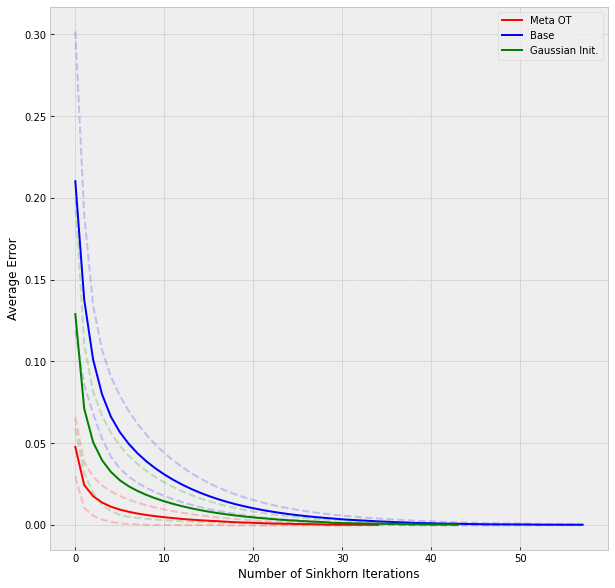

In [136]:
plt.figure(figsize=(10,10))
tag_map = {'meta_ot': 'Meta OT', 'gaus': 'Gaussian Init.', 'base': 'Base'}
col_map = {'meta_ot': 'red', 'gaus': 'green', 'base': 'blue'}

for tag in ['meta_ot', 'base', 'gaus']:
    x = post_process(jnp.array(error_log[tag]), reduction=jnp.mean)
    plt.plot(x, label=tag_map[tag], color=col_map[tag])
    
    std = post_process(jnp.array(error_log[tag]), reduction=jnp.std)
    plt.plot(x+std, color=col_map[tag], linestyle='--', alpha=0.2)
    plt.plot(x-std, color=col_map[tag], linestyle='--', alpha=0.2)
    
plt.xlabel('Number of Sinkhorn Iterations')
plt.ylabel('Average Error')
plt.legend()
plt.show()